<a href="https://colab.research.google.com/github/Edenshmuel/PapaJohns_Data_Science_Project/blob/main/Model_XGboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Required Libraries

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from holidays import country_holidays
import matplotlib.pyplot as plt

### Loading the Dataset

In [57]:
cleaned_data = pd.read_csv('/content/drive/MyDrive/Final_Project_PapaJohns/cleaned_data.csv')

In [7]:
desc_encoding_map = pd.read_csv('/content/drive/MyDrive/Final_Project_PapaJohns/Desc_encoding_map.csv')

### Creating a Working Copy of the Data

In [58]:
df = cleaned_data.copy()

In [59]:
df = df.sort_values('Date')

In [60]:
columns_to_drop = ['Cleaned Description', 'Cleaned Description Normalized', 'Category', 'Date']
df = df.drop(columns=columns_to_drop, errors='ignore')

### Calculate Recent 30-Day Average Quantity per Product


In [61]:
df['Recent_Avg_Quantity'] = (df.groupby('Clean_Desc_Encoded')['Quantity']
    .rolling(window=30, min_periods=1).mean()
    .reset_index(0, drop=True))

### Split Data into Train, Validation, and Test Sets & Train XGBoost Model


In [62]:
train_size = 0.7
val_size = 0.15
test_size = 0.15

n = len(df)
train_end = int(n * train_size)
val_end = int(n * (train_size + val_size))

train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

X_train = train_df.drop(columns=['Quantity'])
y_train = train_df['Quantity']

X_val = val_df.drop(columns=['Quantity'])
y_val = val_df['Quantity']

X_test = test_df.drop(columns=['Quantity'])
y_test = test_df['Quantity']

In [63]:
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

### Evaluate Model Performance and Analyze Feature Importance

In this section, we assess the model's performance on the training, validation, and test sets using metrics like MAE, RMSE, MAPE, R², and Adjusted R². These metrics help us understand how accurate the model is and how well it generalizes to unseen data. We also calculate basic quantity statistics for reference and visualize the most important features according to the XGBoost model, which helps us interpret which inputs have the biggest impact on predictions.


In [64]:
model_features = X_train.columns.tolist()

In [65]:
def extended_evaluate_model(model, X, y, label='Set'):
    y_pred = model.predict(X)

    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mape = np.mean(np.abs((y - y_pred) / np.where(y == 0, 1, y))) * 100
    r2 = r2_score(y, y_pred)

    n = X.shape[0]
    k = X.shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

    print(f'📊 Evaluation on {label}')
    print(f'MAE:  {mae:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'MAPE: {mape:.2f}%')
    print(f'R²:   {r2:.4f}')
    print(f'Adjusted R²: {adj_r2:.4f}')

    return mae, rmse, mape, r2, adj_r2

In [66]:
extended_evaluate_model(model, X_train, y_train, 'Train')
extended_evaluate_model(model, X_val, y_val, 'Validation')
extended_evaluate_model(model, X_test, y_test, 'Test')

📊 Evaluation on Train
MAE:  0.29
RMSE: 0.57
MAPE: 20.34%
R²:   0.9127
Adjusted R²: 0.9126
📊 Evaluation on Validation
MAE:  0.30
RMSE: 0.76
MAPE: 21.05%
R²:   0.2612
Adjusted R²: 0.2606
📊 Evaluation on Test
MAE:  0.29
RMSE: 0.51
MAPE: 20.96%
R²:   0.3981
Adjusted R²: 0.3976


(0.2937958836555481,
 np.float64(0.5106062407298612),
 np.float64(20.960485719329643),
 0.3981167674064636,
 0.39763709423783333)

In [67]:
quantity_min = df['Quantity'].min()
quantity_max = df['Quantity'].max()
quantity_mean = df['Quantity'].mean()
quantity_std = df['Quantity'].std()

quantity_min, quantity_max, quantity_mean, quantity_std

(1, 500, np.float64(1.2800155723961582), 1.6585356916135217)

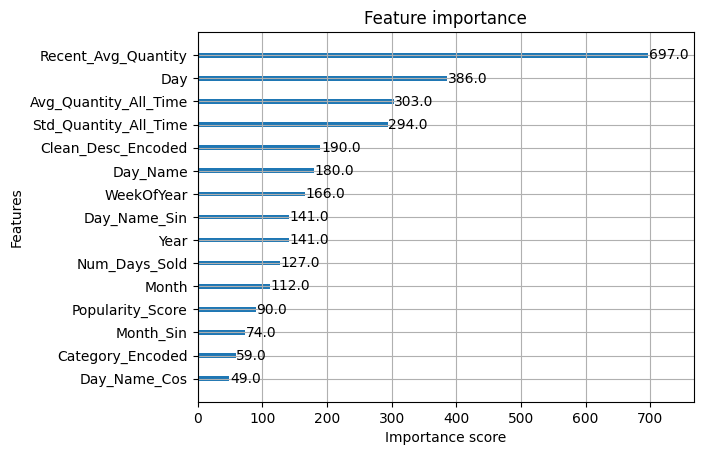

In [68]:
xgb.plot_importance(model, max_num_features=15)
plt.show()

### Forecasting Sales for a Future Date

This process predicts product sales for any chosen future date. It consists of two main steps:

**1. Feature Generation (build_future_features)**

- Creates a feature set for the forecast date, including calendar variables (day, month, year, season, holidays), cyclical encodings for time features, recent sales trends, historical averages, popularity scores, and product attributes.

- Ensures the structure of the generated features matches the model’s training data, so predictions remain consistent.

**2. Prediction (predict_sales_by_date)**

- Uses the generated features to make predictions with the trained model.

- Encodes categorical variables if needed, applies the model to estimate sales quantity, and rounds up results to whole units.

- Returns a sorted list of product categories with their predicted quantities for the given date.

Together, these functions allow the model to generalize and forecast sales for dates it has never seen before, using a combination of historical data patterns and domain-specific features.

In [78]:
def build_future_features(forecast_date: str, full_df, desc_map_df, model_features):
    date = pd.to_datetime(forecast_date)
    day = date.day
    month = date.month
    year = date.year
    week = date.isocalendar().week
    day_name = ((date.dayofweek + 1) % 7) + 1
    is_weekend = int(day_name in [6, 7])

    il_holidays = country_holidays('IL')
    christian_holidays = country_holidays('US')
    is_jewish_holiday = date in il_holidays
    is_christian_holiday = date in christian_holidays
    is_near_jewish_holiday = ((date + pd.Timedelta(days=1) in il_holidays) or
                              (date - pd.Timedelta(days=1) in il_holidays))
    is_day_before_new_year = int(month == 12 and day == 31)
    is_start_of_month = int(day <= 3)
    is_end_of_month = int(day >= 28)
    season = (month % 12) // 3 + 1

    day_name_sin = np.sin(2 * np.pi * day_name / 7)
    day_name_cos = np.cos(2 * np.pi * day_name / 7)
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)

    categories = full_df['Clean_Desc_Encoded'].unique()
    avg_quantity = full_df.groupby('Clean_Desc_Encoded')['Quantity'].mean()
    std_quantity = full_df.groupby('Clean_Desc_Encoded')['Quantity'].std()
    days_sold = full_df.groupby('Clean_Desc_Encoded')['Date'].nunique()
    max_days = days_sold.max()

    portion_map = desc_map_df.set_index('code')['Encoded_Portion_Type'].to_dict() if 'Encoded_Portion_Type' in desc_map_df.columns else {}

    rows = []
    for cat in categories:
        recent_avg = full_df[
            (full_df['Clean_Desc_Encoded'] == cat) &
            (pd.to_datetime(full_df['Date']) < date)
        ].sort_values('Date').tail(30)['Quantity'].mean()

        row = {
            'Clean_Desc_Encoded': cat,
            'Year': year, 'Month': month, 'Day': day, 'WeekOfYear': week,
            'Day_Name': day_name, 'Is_Weekend': is_weekend,
            'Is_Jewish_Holiday': is_jewish_holiday,
            'Is_Christian_Holiday': is_christian_holiday,
            'Is_Near_Jewish_Holiday': is_near_jewish_holiday,
            'Is_Day_Before_New_Year': is_day_before_new_year,
            'Is_Start_of_Month': is_start_of_month,
            'Is_End_of_Month': is_end_of_month,
            'Season': season,
            'Day_Name_Sin': day_name_sin, 'Day_Name_Cos': day_name_cos,
            'Month_Sin': month_sin, 'Month_Cos': month_cos,
            'Recent_Avg_Quantity': recent_avg if not np.isnan(recent_avg) else 0,
            'Avg_Quantity_All_Time': avg_quantity.get(cat, 0),
            'Std_Quantity_All_Time': std_quantity.get(cat, 0),
            'Num_Days_Sold': days_sold.get(cat, 0),
            'Popularity_Score': days_sold.get(cat, 0) / max_days if max_days > 0 else 0,
            'Encoded_Portion_Type': portion_map.get(cat, 'unknown')
        }

        for col in model_features:
            if col not in row:
                row[col] = 0

        rows.append(row)

    future_df = pd.DataFrame(rows)
    desc_map_dict = desc_map_df.set_index('code')['Unnamed: 0'].to_dict()
    future_df['Category_Name'] = future_df['Clean_Desc_Encoded'].map(desc_map_dict)

    return future_df

In [79]:
def predict_sales_by_date(forecast_date: str, model, full_df, model_features, desc_map_df):
    future_df = build_future_features(
        forecast_date=forecast_date,
        full_df=full_df,
        desc_map_df=desc_map_df,
        model_features=model_features
    )

    if 'Encoded_Portion_Type' in future_df.columns and future_df['Encoded_Portion_Type'].dtype == 'object':
        le = LabelEncoder()
        future_df['Encoded_Portion_Type'] = le.fit_transform(future_df['Encoded_Portion_Type'])

    future_df['Predicted_Quantity'] = np.ceil(model.predict(future_df[model_features])).astype(int)

    return future_df[['Category_Name', 'Predicted_Quantity']].sort_values(by='Predicted_Quantity', ascending=False)

Generate and display the top predicted product categories for January 3, 2025, sorted by forecasted quantity.

In [80]:
forecast_df = predict_sales_by_date(
    forecast_date='2025-01-03',
    model=model,
    full_df=cleaned_data,
    model_features=model_features,
    desc_map_df=desc_encoding_map)

forecast_df.head()

,Category_Name,Predicted_Quantity
457,חגיגות קינוח,24
501,נאגטס עוף,8
89,פיצות אישיות,5
320,פאפא נאגטס יח,5
303,פיצות משפחתיות rl,4


Generate predicted quantities for each product category for the date range January 1–7, 2025, including the corresponding date for each forecast.

In [81]:
def predict_sales_by_date_range(start_date, end_date, model, full_df, model_features, desc_map_df):
    dates = pd.date_range(start=start_date, end=end_date)
    all_rows = []

    for single_date in dates:
        daily = predict_sales_by_date(
            forecast_date=single_date.strftime('%Y-%m-%d'),
            model=model,
            full_df=full_df,
            model_features=model_features,
            desc_map_df=desc_map_df
        )
        daily['Date'] = single_date
        all_rows.append(daily)

    return pd.concat(all_rows, ignore_index=True)

In [82]:
xgb_forecast_range = predict_sales_by_date_range(
    start_date='2025-01-01',
    end_date='2025-01-07',
    model=model,
    full_df=cleaned_data,
    model_features=model_features,
    desc_map_df=desc_encoding_map)

In [83]:
xgb_forecast_range

,Category_Name,Predicted_Quantity,Date
0,חגיגות קינוח,24,2025-01-01
1,נאגטס עוף,9,2025-01-01
2,פיצות אישיות,5,2025-01-01
3,אצבעות מוצרלה יח,4,2025-01-01
4,פאפא נאגטס יח,4,2025-01-01
...,...,...,...
3789,פיצת שף משפחתית,1,2025-01-07
3790,פיצה משפחתית l,1,2025-01-07
3791,פסטו ארטישוק 16,1,2025-01-07
3792,לחמעגון טבעוני 14,1,2025-01-07


### Sales Forecast with XGBoost + SARIMA Residual Correction

In this step, we extend the original XGBoost-based sales prediction by incorporating a SARIMA model to correct for time-series residual patterns.
The workflow is as follows:

1. XGBoost Prediction – Generates initial forecasts based on the engineered features.

2. Residual Calculation – For each product category, we compute the difference between historical actuals and XGBoost predictions.

3. SARIMA Modeling – A SARIMA model (1,1,1) with seasonal order (1,1,1,7) is fitted to the residuals, capturing short-term seasonal patterns.

4. Forecast Adjustment – The SARIMA forecast is added to the XGBoost predictions to produce a corrected Predicted_Quantity.

This approach combines the predictive power of machine learning with the time-series seasonality captured by SARIMA, resulting in more accurate forecasts for January 3, 2025.


In [84]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def predict_sales_with_sarima(forecast_date: str, model, full_df, model_features, desc_map_df):
    future_df = build_future_features(
        forecast_date=forecast_date,
        full_df=full_df,
        desc_map_df=desc_map_df,
        model_features=model_features
    )

    if 'Encoded_Portion_Type' in future_df.columns and future_df['Encoded_Portion_Type'].dtype == 'object':
        le = LabelEncoder()
        future_df['Encoded_Portion_Type'] = le.fit_transform(future_df['Encoded_Portion_Type'])

    categories = future_df['Clean_Desc_Encoded'].unique()
    future_df_model_input = future_df[model_features]
    xgb_pred = model.predict(future_df_model_input)

    sarima_correction = []
    for cat in categories:
        cat_df = full_df[full_df['Clean_Desc_Encoded'] == cat].copy()
        cat_df['Date'] = pd.to_datetime(cat_df['Date'])
        cat_df = cat_df.sort_values('Date').set_index('Date')

        try:
            X_cat = cat_df[model_features]
            y_cat = cat_df['Quantity']
            y_pred = model.predict(X_cat)
            residuals = y_cat - y_pred
        except:
            sarima_correction.append(0)
            continue

        if len(residuals) < 30:
            sarima_correction.append(0)
            continue

        try:
            sarima = SARIMAX(residuals, order=(1,1,1), seasonal_order=(1,1,1,7))
            sarima_fitted = sarima.fit(disp=False)
            forecast = sarima_fitted.forecast(steps=1)[0]
        except:
            forecast = 0

        sarima_correction.append(forecast)

    future_df['Predicted_Quantity'] = np.ceil(xgb_pred + sarima_correction).astype(int)
    future_df['Date'] = forecast_date

    return future_df[['Date', 'Category_Name', 'Predicted_Quantity']].sort_values(by='Predicted_Quantity', ascending=False)

In [85]:
forecast = predict_sales_with_sarima(
    forecast_date='2025-01-03',
    model=model,
    full_df=cleaned_data,
    model_features=model_features,
    desc_map_df=desc_encoding_map)

In [86]:
forecast.head()

,Date,Category_Name,Predicted_Quantity
457,2025-01-03,חגיגות קינוח,24
501,2025-01-03,נאגטס עוף,8
89,2025-01-03,פיצות אישיות,5
320,2025-01-03,פאפא נאגטס יח,5
303,2025-01-03,פיצות משפחתיות rl,4


### predict_sales_with_sarima_range



In [87]:
def predict_sales_with_sarima_range(start_date: str, end_date: str, model, full_df, model_features, desc_map_df, verbose=False):
    date_range = pd.date_range(start=start_date, end=end_date)
    all_forecasts = []

    for single_date in date_range:
        if verbose:
            print("📅 Forecasting for:", single_date.strftime('%Y-%m-%d'))

        daily_forecast = predict_sales_with_sarima(
            forecast_date=single_date.strftime('%Y-%m-%d'),
            model=model,
            full_df=full_df,
            model_features=model_features,
            desc_map_df=desc_map_df
        )

        all_forecasts.append(daily_forecast)

    forecast_df = pd.concat(all_forecasts, ignore_index=True)

    return forecast_df[['Date', 'Category_Name', 'Predicted_Quantity']]\
        .sort_values(by=['Date', 'Predicted_Quantity'], ascending=[True, False])

In [88]:
hybrid_forecast_range = predict_sales_with_sarima_range(
    start_date='2025-01-01',
    end_date='2025-01-07',
    model=model,
    full_df=cleaned_data,
    model_features=model_features,
    desc_map_df=desc_encoding_map)

In [89]:
hybrid_forecast_range

,Date,Category_Name,Predicted_Quantity
0,2025-01-01,חגיגות קינוח,24
1,2025-01-01,נאגטס עוף,9
2,2025-01-01,פיצות אישיות,5
3,2025-01-01,אצבעות מוצרלה יח,4
4,2025-01-01,פאפא נאגטס יח,4
...,...,...,...
3789,2025-01-07,פיצת שף משפחתית,1
3790,2025-01-07,פיצה משפחתית l,1
3791,2025-01-07,פסטו ארטישוק 16,1
3792,2025-01-07,לחמעגון טבעוני 14,1


### Summarizing Daily Sales Forecast
This step aggregates the detailed product‑level forecasts into total predicted sales per day.
It helps identify overall demand trends over the forecast period rather than individual item predictions.

In [92]:
def summarize_daily_forecast(forecast_df):
    return (
        forecast_df
        .groupby('Date', as_index=False)
        .agg(total_predicted_sales=('Predicted_Quantity', 'sum'))
        .sort_values('Date'))

In [93]:
hybrid_forecast_range = predict_sales_with_sarima_range(
    start_date='2025-01-01',
    end_date='2025-01-07',
    model=model,
    full_df=cleaned_data,
    model_features=model_features,
    desc_map_df=desc_encoding_map)

daily_summary = summarize_daily_forecast(hybrid_forecast_range)

In [94]:
daily_summary

,Date,total_predicted_sales
0,2025-01-01,1158
1,2025-01-02,1188
2,2025-01-03,1180
3,2025-01-04,1184
4,2025-01-05,866
5,2025-01-06,866
6,2025-01-07,938


In [95]:
def plot_daily_forecast(summary_df):
    plt.figure(figsize=(10, 5))
    plt.plot(summary_df['Date'], summary_df['total_predicted_sales'], marker='o')
    plt.title("Daily forecast of total expected sales")
    plt.xlabel("Date")
    plt.ylabel("Total expected items")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

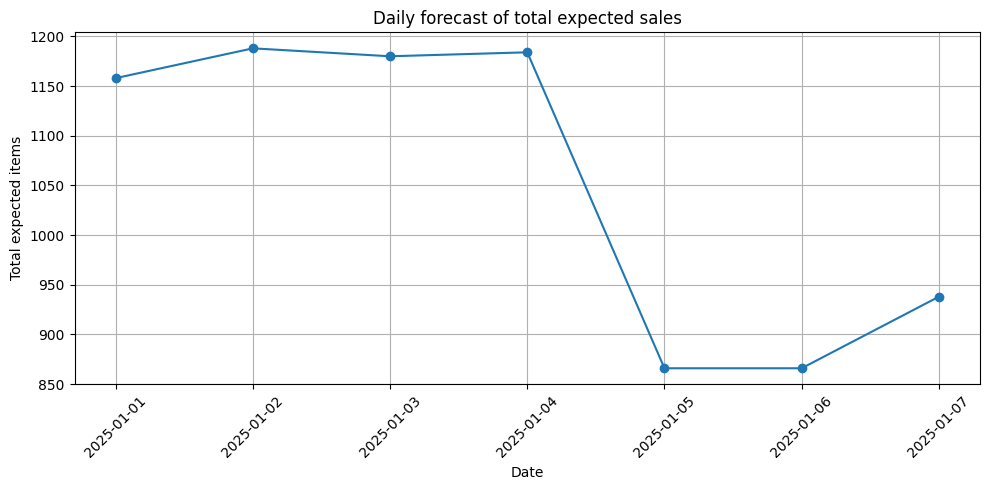

In [96]:
plot_daily_forecast(daily_summary)

### Comparing Forecast Models (XGBoost vs. Hybrid XGBoost + SARIMA)
In this step, I generate daily forecasts using two approaches — XGBoost alone and a hybrid XGBoost + SARIMA model.
The results are aggregated by day, merged into a single table, and plotted to visually compare their predicted sales trends over the same date range.

In [97]:
xgb_only_forecast = predict_sales_by_date_range(
    start_date='2025-01-01',
    end_date='2025-01-07',
    model=model,
    full_df=cleaned_data,
    model_features=model_features,
    desc_map_df=desc_encoding_map)

sarima_forecast = predict_sales_with_sarima_range(
    start_date='2025-01-01',
    end_date='2025-01-07',
    model=model,
    full_df=cleaned_data,
    model_features=model_features,
    desc_map_df=desc_encoding_map)

In [98]:
xgb_summary = summarize_daily_forecast(xgb_only_forecast)
sarima_summary = summarize_daily_forecast(sarima_forecast)

In [99]:
xgb_summary['Date'] = pd.to_datetime(xgb_summary['Date'])
sarima_summary['Date'] = pd.to_datetime(sarima_summary['Date'])

In [100]:
comparison_df = pd.merge(
    xgb_summary.rename(columns={'total_predicted_sales': 'XGBoost'}),
    sarima_summary.rename(columns={'total_predicted_sales': 'XGBoost + SARIMA'}),
    on='Date')

In [101]:
def plot_forecast_comparison(comparison_df):
    plt.figure(figsize=(10, 5))
    plt.plot(comparison_df['Date'], comparison_df['XGBoost'], marker='o', label='XGBoost')
    plt.plot(comparison_df['Date'], comparison_df['XGBoost + SARIMA'], marker='s', label='XGBoost + SARIMA')
    plt.title("Daily Forecast Comparison: XGBoost vs. XGBoost + SARIMA")
    plt.xlabel("Date")
    plt.ylabel("Total expected items")
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

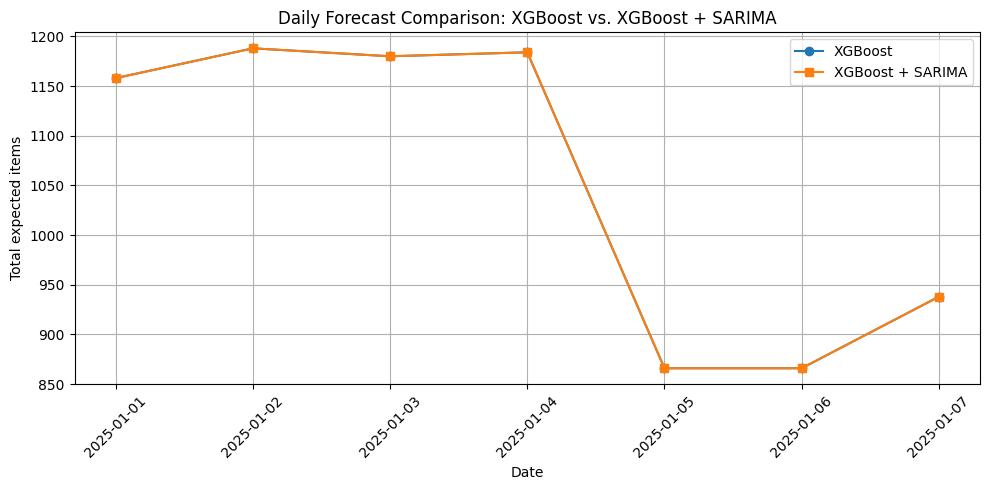

In [102]:
plot_forecast_comparison(comparison_df)

In [103]:
(comparison_df['XGBoost'] == comparison_df['XGBoost + SARIMA']).all()

np.True_